In [1]:
import pandas as pd              #Обработка табличных данных
import numpy as np               #Алгоритмы линейной алгебры
import matplotlib.pyplot as plt  #Различные способы визуализации


%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

#### Предобработка данных

Считываем данные из csv файла

In [2]:
df = pd.read_csv('application_info.csv', index_col='id')
y = pd.read_csv('default_flg.csv', index_col='id')

In [3]:
train_index    = df[df.sample_cd =='train'].sample_cd.index
validate_index = df[df.sample_cd =='validate'].sample_cd.index
# индекс чтоб по-больше обучить выборку в конце
train_valid= df[(df.sample_cd =='train')|(df.sample_cd =='validate')].sample_cd.index
test_index     = df[df.sample_cd =='test'].sample_cd.index
train_valid    = df[(df.sample_cd =='train')|(df.sample_cd =='validate')].sample_cd.index

df.drop(['sample_cd','application_dt'],axis=1,inplace=True) #Удаляем два столбца из выборки

Список категориальных полей

In [4]:
category_columns = [col for col in df.columns if df.dtypes[col] == 'object']
df.education_cd.fillna('SCH', inplace=True)

Производим dummy кодирование не числовых полей

In [5]:
data_category = pd.get_dummies(df[category_columns], drop_first=True)

Заменяем не числовые поля на dummy кодированные

In [6]:
df.drop(category_columns, axis=1, inplace=True)
df = pd.concat([df, data_category], axis=1)
df.head(2)

,age,appl_rej_cnt,good_work_flg,Score_bki,out_request_cnt,region_rating,home_address_cd,work_address_cd,income,SNA,first_time_cd,education_cd_GRD,education_cd_PGR,education_cd_SCH,education_cd_UGR,gender_cd_M,car_own_flg_Y,car_type_flg_Y,Air_flg_Y
id,,,,,,,,,,,,,,,,,,,
1,27,0,0,-1.917831,0,40,2,3,32000,1,4,0,0,1,0,1,1,1,0
2,26,0,0,-1.153144,2,60,2,3,50000,2,1,1,0,0,0,0,0,0,0


In [7]:
Посмотрим на корреляцию:
не большая она, попробовала выкинуть что-то - auc упал

SyntaxError: invalid syntax (<ipython-input-7-b1211aab25e7>, line 1)

In [8]:
CorrKoef = df.corr()
CorField = []
for i in CorrKoef:
    for j in CorrKoef.index[CorrKoef[i] > 0.6]:
        if i!=j:
            CorField.append(j)
            print ('%s-->%s: r^2=%f' % (i,j, CorrKoef[i][CorrKoef.index==j].values[0]))

home_address_cd-->work_address_cd: r^2=0.740874
work_address_cd-->home_address_cd: r^2=0.740874
car_own_flg_Y-->car_type_flg_Y: r^2=0.700206
car_type_flg_Y-->car_own_flg_Y: r^2=0.700206


# Вспомогательные функции


##### WoE (weight of evidence)
 - На вход подается бинарная целевая переменная $target$, признак $feature$ и количество бакетов $k$
 - Признак разбивается на бакеты  с номерами $0 \le i \le k$. 
 - Считаем долю значений целевой переменной $tr$ и количество наблюдений $cnt$
 - Считаем $WoE_i = \ln\left(\frac{tr_i}{tr}\right) - \ln\left(\frac{1-tr_i}{1-tr}\right)$
 - Рисуем зависимость $WoE_i$ от среднего значения признака в бакте
 
###### IV (Information Value)
 - На вход подается бинарная целевая переменная $target$, признак $feature$ и количество бакетов $k$
 - Признак разбивается на бакеты  с номерами $0 \le i \le k$. 
 - Считаем долю значений целевой переменной $tr$ и количество наблюдений $cnt$
 - Считаем долю значений целевой переменной в каждом бакете $tr_i$ и количество наблюдений в каждом бакете $cnt_i$
 - Считается $ IV = \sum\limits_{i}{\left(\frac{tr_i}{tr} - \frac{1-tr_i}{1-tr}\right)\left(\ln\left(\frac{tr_i}{tr}\right) - \ln\left(\frac{1-tr_i}{1-tr}\right)\right)\left(\frac{cnt_i}{cnt}\right)}$
 - Слагаемые, в которых $tr_i=0$ или $tr_i=1$, сглаживаем до $tr_i=0.001$ и $tr_i=0.999$ соответственно

In [9]:
def WoE(target, feature, nbuck=10):
    """Функция, русующая зависимость WoE от среднего значения признака в бакете"""
    #Копируем данные
    df = pd.DataFrame()
    df['target']  = target.copy()
    df['feature'] = feature.copy()
    #Считаем номер бакета
    df['feature_buck'] = df['feature'].rank(method='min', pct=1, na_option = 'top').apply(
        lambda x: int((x- 1/df.shape[0])*nbuck))
    #Запоминаем среднее значение целевой переменной и кол-во наблюдений
    tr  = df['target'].mean()
    cnt = df['target'].count()
    #Агрегируем по каждому бакету
    df = df.groupby('feature_buck')['target' ].agg({'tr': 'mean','cnt': 'size'}).join(
        df.groupby('feature_buck')['feature'].agg({'feature_av': 'mean'}))
    #В случае крайних значений tr делаем сглаживание
    df.tr = df.tr.apply(lambda x: max(0.001, min(0.999, x)))
    #считаем WoE
    df.eval('WoE = log(tr/@tr)-log((1-tr)/(1-@tr))', inplace=True)
    #Погрешность WoE
    df.eval('WoE_d = 2/sqrt(tr*(1-tr)*cnt)', inplace=True) 
    #убираем наблюдения с пустым значением признака
    df.dropna(inplace=True)
    #Рисуем график
    fig = plt.gcf()
    plt.grid(True)
    plt.errorbar(df['feature_av'], df.WoE, yerr=np.array((df['WoE_d'])))
    plt.xlabel('feature')
    plt.ylabel('WoE')
    plt.show()

def IV(target, feature, nbuck=10):
    """Функция, возвращающая IV признака-feature с целевой переменной target"""
    #Копируем данные
    df = pd.DataFrame()
    df['target']  = target.copy()
    df['feature'] = feature.copy()
    #Считаем номер бакета
    df['feature_buck'] = df['feature'].rank(method='min', pct=1, na_option = 'top').apply(
        lambda x: int((x- 1.0/df.shape[0])*nbuck))
    #Запоминаем среднее значение целевой переменной и кол-во наблюдений
    tr  = df['target'].mean()
    cnt = df['target'].count()
    #Агрегируем по каждому бакету
    df = df.groupby('feature_buck')['target'].agg({'tr': 'mean','cnt': 'size'})
    #В случае крайних значений tr делаем сглаживание
    df.tr = df.tr.apply(lambda x: max(0.001, min(0.999, x)))
    #Считаем IV
    df.eval('IV = ( (tr/@tr) - ((1-tr)/(1-@tr))) * (log(tr/@tr) - log((1-tr)/(1-@tr)) ) * (cnt/@cnt)', inplace=True)
    IV = df.IV.sum()
    return IV

#### WoE

Зависимость WoE от признака

#### собственно дальше очень долго нормализуем признаки, пытаемя выявить лог-нормальные распределения, ну и на флаги заменить.в принципе, после смены логистической регресси на градиентный бустинг это стало довольно сильно влиять (что странно)

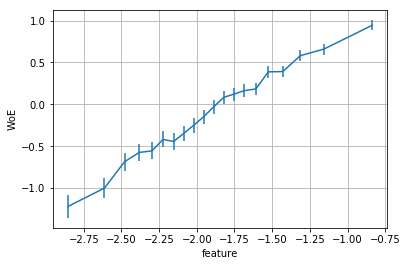

In [10]:
WoE(y.loc[train_index].default_flg, df.loc[train_index].Score_bki, nbuck=20)

Считаем IV

In [11]:
IV(y.loc[train_index].default_flg, df.loc[train_index].Score_bki, nbuck=20)

0.283108532383257

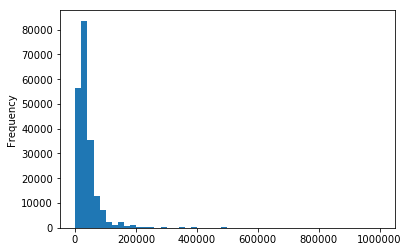

In [12]:
df.income.plot.hist(bins=50);

У признака доход зависимость WoE не такая линейная, как у Score_bki.

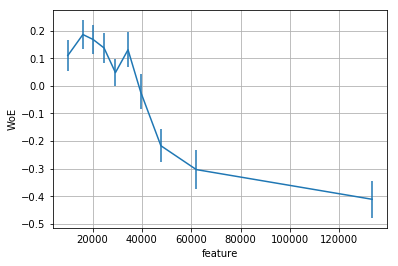

In [13]:
WoE(y.loc[train_index].default_flg, df.loc[train_index].income, nbuck=10)

Посчитаем IV от различных преобразований поля income

In [14]:
print (IV(y.loc[train_index].default_flg, df.loc[train_index].income, nbuck=10))
print (IV(y.loc[train_index].default_flg, df.loc[train_index].income.apply(lambda x: np.log(x)), nbuck=10))
print (IV(y.loc[train_index].default_flg, df.loc[train_index].income.apply(lambda x: int(x > 40000)), nbuck=10))

0.03837794897479724
0.03837794897479724
0.03354139550049351


In [15]:
df['income'] = df.income.apply(lambda x: np.log(x))

Видно, что iv у флага "доход > 40000" не сильно меньше, поэтому вводим флаг в замен старого признака.

df['income_40k_flg'] = df.income.apply(lambda x: int(x > 40000))
df.drop('income', axis=1, inplace=True)

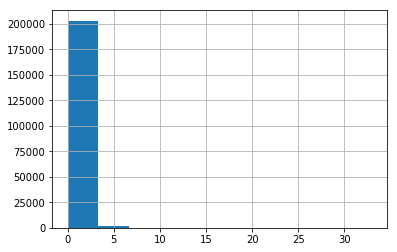

In [16]:
df.appl_rej_cnt.hist()

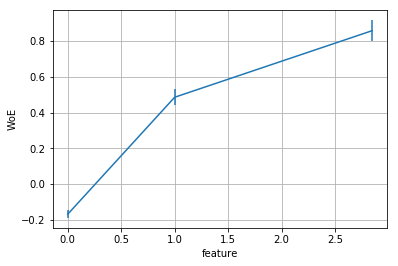

In [17]:
WoE(y.loc[train_index].default_flg, df.loc[train_index].appl_rej_cnt, nbuck=10)

In [18]:
print (IV(y.loc[train_index].default_flg, df.loc[train_index].appl_rej_cnt, nbuck=10))
print (IV(y.loc[train_index].default_flg, df.loc[train_index].appl_rej_cnt.apply(lambda x: int(x <1)), nbuck=10))

0.10974374576408974
0.10279484257106726


In [19]:
#df['appl_rej_cnt'] = df.appl_rej_cnt.apply(lambda x: int(x<1))

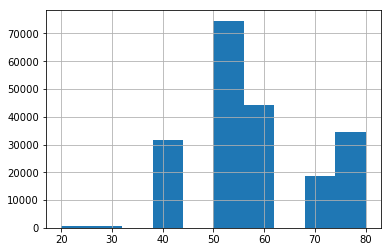

In [20]:
df.region_rating.hist()

In [1]:
print (IV(y.loc[train_index].default_flg, df.loc[train_index].region_rating, nbuck=10))
print (IV(y.loc[train_index].default_flg, df.loc[train_index].region_rating.apply(lambda x: int(x >=50)), nbuck=10))

NameError: name 'IV' is not defined

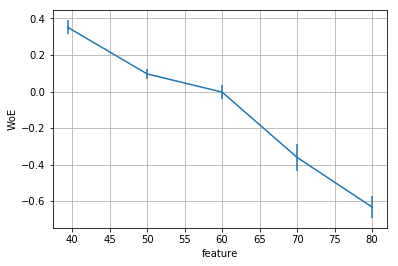

In [21]:
WoE(y.loc[train_index].default_flg, df.loc[train_index].region_rating, nbuck=10)

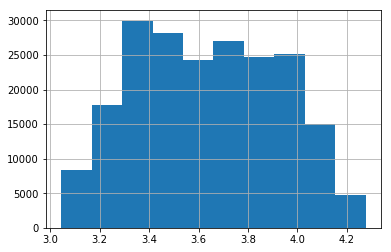

In [22]:
df.age.apply(lambda x: np.log(x)).hist()

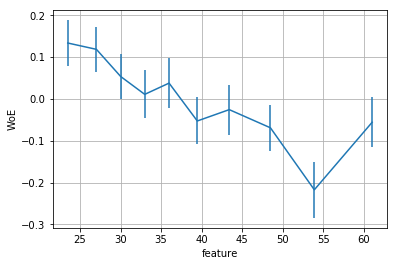

In [23]:
WoE(y.loc[train_index].default_flg, df.loc[train_index].age, nbuck=10)


In [24]:
print (IV(y.loc[train_index].default_flg, df.loc[train_index].age, nbuck=10))
print (IV(y.loc[train_index].default_flg, df.loc[train_index].age.apply(lambda x: int(x <55)), nbuck=10))
print (IV(y.loc[train_index].default_flg, df.loc[train_index].age.apply(lambda x: np.log(x)), nbuck=10))

0.008811654707370572
0.0012179846608792245
0.008811654707370572


In [25]:
df['age'] = df.age.apply(lambda x: np.log(x))

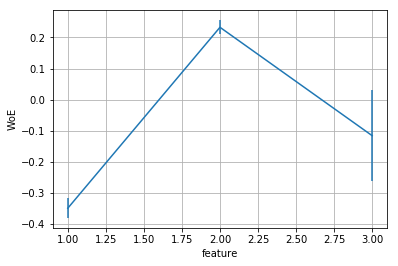

In [26]:
WoE(y.loc[train_index].default_flg, df.loc[train_index].home_address_cd, nbuck=10)

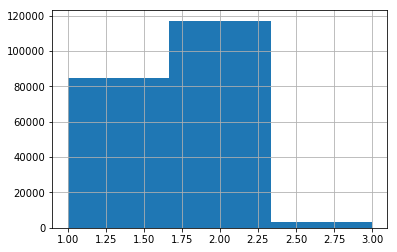

In [27]:
df.home_address_cd.hist(bins=3)

In [28]:
print (IV(y.loc[train_index].default_flg, df.loc[train_index].home_address_cd, nbuck=10))
print (IV(y.loc[train_index].default_flg, df.loc[train_index].home_address_cd.apply(lambda x: int(x < 2)), nbuck=10))

0.07932921738348321
0.0774015181711397


In [29]:
df['home_address_cd'] = df.home_address_cd.apply(lambda x: int(x<2))

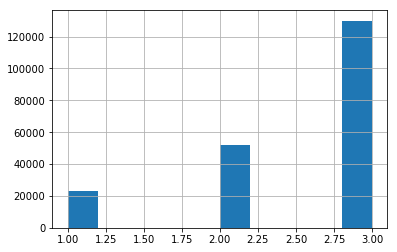

In [30]:
df.work_address_cd.hist()

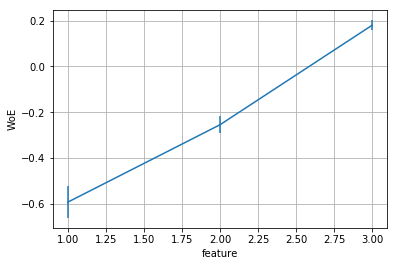

In [31]:
WoE(y.loc[train_index].default_flg, df.loc[train_index].work_address_cd, nbuck=10)

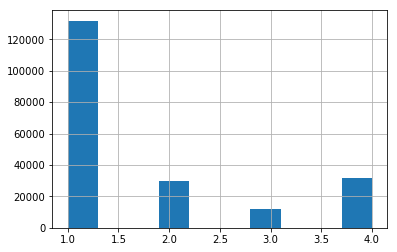

In [32]:
df.SNA.hist()

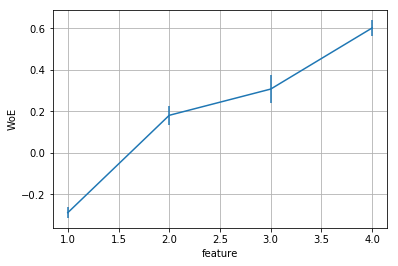

In [33]:
WoE(y.loc[train_index].default_flg, df.loc[train_index].SNA, nbuck=10)

In [34]:
print (IV(y.loc[train_index].default_flg, df.loc[train_index].SNA, nbuck=10))
print (IV(y.loc[train_index].default_flg, df.loc[train_index].SNA.apply(lambda x: int(x > 1)), nbuck=10))

0.13029581648510263
0.11412547623457028


In [35]:
df['SNA']=df.SNA.apply(lambda x: np.log(x))

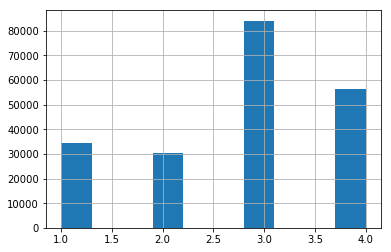

In [36]:
df.first_time_cd.hist()

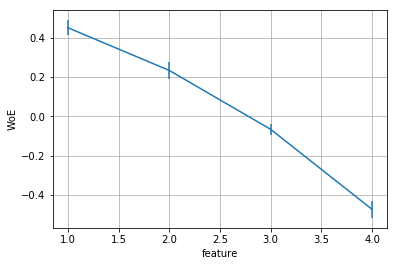

In [37]:
WoE(y.loc[train_index].default_flg, df.loc[train_index].first_time_cd, nbuck=10)

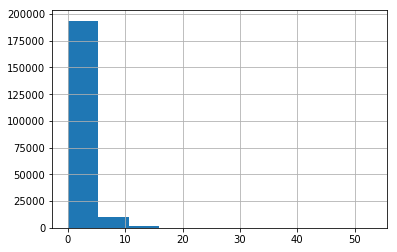

In [38]:
df.out_request_cnt.hist()

In [39]:
df['out_request_cnt']=df.out_request_cnt.apply(lambda x: np.log(x+0.000001))

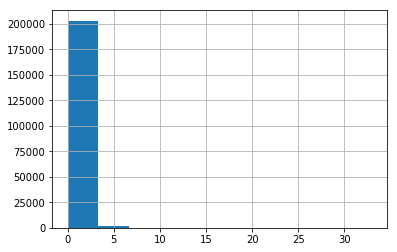

In [40]:
df.appl_rej_cnt.hist()

In [41]:
df['appl_rej_cnt']=df.appl_rej_cnt.apply(lambda x: np.log(x+0.000001))

#### пробуем разные модели обучения с разными параметрами. SVM так и не хватило терпения дождаться (3 часа) пока доработает, так что без него. Как уже писала выше, градиентный бустинг показал наилучший результат

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn import cross_validation, svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.metrics import roc_curve, auc
import pylab as pl

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [43]:
#LR
print ('%8s %8s %4s' % ('Train','Validate','C'))
for C in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]:
    LR = LogisticRegression(C=C, penalty='l2')
    LR.fit(df.loc[train_index], y.loc[train_index].default_flg)
    AUC_train = roc_auc_score(y.loc[train_index].default_flg, LR.predict_proba(df.loc[train_index])[:,1])
    AUC_validate = roc_auc_score(y.loc[validate_index].default_flg, LR.predict_proba(df.loc[validate_index])[:,1])
    print('%.6f %.6f %f' %  (AUC_train, AUC_validate, C))

   Train Validate    C
0.647542 0.638841 0.000010
0.700665 0.679501 0.000100
0.727982 0.710074 0.001000
0.729872 0.714760 0.010000
0.730271 0.715848 0.100000
0.730303 0.716022 1.000000
0.730279 0.716156 10.000000
0.730312 0.716051 100.000000


In [44]:
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(df.loc[train_index], y.loc[train_index].default_flg)
# display the relative importance of each attribute
print(model.feature_importances_)

[ 0.17948176  0.03319686  0.0178641   0.21507438  0.09685031  0.08014496
  0.01044936  0.01921374  0.17313239  0.03925008  0.04763916  0.00566982
  0.00193385  0.00674664  0.00592731  0.02454827  0.01975888  0.01185749
  0.01126064]


In [ ]:
#### тут нужны не отрицательные параметры, поэтому не будем пока менять данные
#naivi bayes
df['Score_bki']=abs(df['Score_bki'])
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(df.loc[train_index], y.loc[train_index].default_flg)
AUC_train = roc_auc_score(y.loc[train_index].default_flg,clf.predict_proba(df.loc[train_index])[:,1])
AUC_validate = roc_auc_score(y.loc[validate_index].default_flg, clf.predict_proba(df.loc[validate_index])[:,1])
print('%.6f %.6f ' %  (AUC_train, AUC_validate))

In [45]:
#GAussian
print ('%8s %8s ' % ('Train','Validate'))
model_GNB = GaussianNB()
model_GNB.fit(df.loc[train_index], y.loc[train_index].default_flg)
AUC_train = roc_auc_score(y.loc[train_index].default_flg, model_GNB.predict_proba(df.loc[train_index])[:,1])
AUC_validate = roc_auc_score(y.loc[validate_index].default_flg, model_GNB.predict_proba(df.loc[validate_index])[:,1])
print('%.6f %.6f ' %  (AUC_train, AUC_validate))

   Train Validate 
0.696733 0.684229 


In [46]:
#random forest
print ('%8s %8s %4s' % ('Train','Validate','n'))
for n in [100,  150, 500, 750, 1000]:
    model_rfc = RandomForestClassifier(n_estimators = n)
    model_rfc.fit(df.loc[train_index], y.loc[train_index].default_flg)
    AUC_train = roc_auc_score(y.loc[train_index].default_flg, model_rfc.predict_proba(df.loc[train_index])[:,1])
    AUC_validate = roc_auc_score(y.loc[validate_index].default_flg, model_rfc.predict_proba(df.loc[validate_index])[:,1])
    print('%.6f %.6f %f' %  (AUC_train, AUC_validate, n))

   Train Validate    n
1.000000 0.688512 100.000000
1.000000 0.690003 150.000000
1.000000 0.695984 500.000000
1.000000 0.695182 750.000000
1.000000 0.696193 1000.000000


In [47]:
#random forest +
model_rfc = RandomForestClassifier(n_estimators=500, max_depth=4, criterion='entropy')
model_rfc.fit(df.loc[train_index], y.loc[train_index].default_flg)
AUC_train = roc_auc_score(y.loc[train_index].default_flg, model_rfc.predict_proba(df.loc[train_index])[:,1])
AUC_validate = roc_auc_score(y.loc[validate_index].default_flg, model_rfc.predict_proba(df.loc[validate_index])[:,1])
print('%.6f %.6f' %  (AUC_train, AUC_validate))

0.721016 0.702796


In [48]:
from sklearn import preprocessing
# normalize the data attributes
normalized_X = preprocessing.normalize(df)
# standardize the data attributes
standardized_X =pd.DataFrame( preprocessing.scale(df))

In [49]:
#neighbors
print ('%8s %8s %4s' % ('Train','Validate','n'))
for n in [5, 10, 15, 20]:
    model_knc = KNeighborsClassifier(n_neighbors = 18)
    model_knc.fit(standardized_X.loc[train_index], y.loc[train_index].default_flg)
    AUC_train = roc_auc_score(y.loc[train_index].default_flg, model_knc.predict_proba(standardized_X.loc[train_index])[:,1])
    AUC_validate = roc_auc_score(y.loc[validate_index].default_flg, model_knc.predict_proba(standardized_X.loc[validate_index])[:,1])
    print('%.6f %.6f %f' %  (AUC_train, AUC_validate, n))

   Train Validate    n
0.695510 0.501695 5.000000
0.695510 0.501695 10.000000
0.695510 0.501695 15.000000
0.695510 0.501695 20.000000


In [ ]:
#svc
print ('%8s %8s ' % ('Train','Validate'))
model_svc = svm.SVC()
model_svc.fit(df.loc[train_index], y.loc[train_index].default_flg)
AUC_train = roc_auc_score(y.loc[train_index].default_flg, model_svc.predict_proba(df.loc[train_index])[:,1])
AUC_validate = roc_auc_score(y.loc[validate_index].default_flg, model_svc.predict_proba(df.loc[validate_index])[:,1])
print('%.6f %.6f ' %  (AUC_train, AUC_validate))

In [50]:
#GB
print ('%8s %8s %4s' % ('Train','Validate','n'))
for n in [4,5,6]:
    model_GBC = GradientBoostingClassifier(max_depth =n )
    model_GBC.fit(df.loc[train_index], y.loc[train_index].default_flg)
    AUC_train = roc_auc_score(y.loc[train_index].default_flg, model_GBC.predict_proba(df.loc[train_index])[:,1])
    AUC_validate = roc_auc_score(y.loc[validate_index].default_flg, model_GBC.predict_proba(df.loc[validate_index])[:,1])
    print('%.6f %.6f %f' %  (AUC_train, AUC_validate, n))

   Train Validate    n
0.751094 0.720168 4.000000
0.763114 0.720899 5.000000
0.783065 0.719688 6.000000


#### здесь, после того как определилась с методом обучения по не преобразованным данным, смотрела как влияет нормализация на auc

In [ ]:
#GB
model_GBC = GradientBoostingClassifier(max_depth =5)
model_GBC.fit(df.loc[train_index], y.loc[train_index].default_flg)
AUC_train = roc_auc_score(y.loc[train_index].default_flg, model_GBC.predict_proba(df.loc[train_index])[:,1])
AUC_validate = roc_auc_score(y.loc[validate_index].default_flg, model_GBC.predict_proba(df.loc[validate_index])[:,1])
print('%.6f %.6f ' %  (AUC_train, AUC_validate))

0.761730 0.719217 5.000000
age 0.761730 0.719340 5.000000
home
age+home 0.760745 0.720149 5.000000
+SNA 0.760417 0.716843 5.000000
+log SNA 0.760745 0.720173 5.000000

log incom 0.762834 0.720518 5.000000
+log  incom 0.763114 0.720959 5.000000


#попытка ввести признак из соображения природы данных: отношение отклоненных заявок к общему, но только хуже стало
+ appl_rej_cnt/out_request_cnt 0.758633 0.719399 5.000000
+ - app 0.759176 0.713846 
+ log out 0.763114 0.720928 
+log app 0.763114 0.720884 

#### попытка применить кросс-валидацию на тестовой выборке, но точность чуть упала((

In [ ]:
part1 = train_index [train_index < 22030]
part2 = train_index [(train_index < 44060)&(train_index >=22030)]
part3 = train_index [(train_index < 66090)&(train_index >=44060)]
part4 = train_index [(train_index < 88120)&(train_index >=66090)]
part5 = train_index [(train_index >=88120)]

In [53]:
model_GBC = GradientBoostingClassifier(max_depth =5)


pred=pd.DataFrame(index=validate_index)

model_GBC.fit(df.loc[part1.append(part2).append(part3).append(part4)], y.loc[part1.append(part2).append(part3).append(part4)].default_flg)
pred['1']= model_GBC.predict_proba(df.loc[validate_index])[:,1]
model_GBC.fit(df.loc[part1.append(part2).append(part3).append(part5)], y.loc[part1.append(part2).append(part3).append(part5)].default_flg)
pred['2']= model_GBC.predict_proba(df.loc[validate_index])[:,1]
model_GBC.fit(df.loc[part1.append(part2).append(part4).append(part5)], y.loc[part1.append(part2).append(part4).append(part5)].default_flg)
pred['3']= model_GBC.predict_proba(df.loc[validate_index])[:,1]
model_GBC.fit(df.loc[part1.append(part3).append(part4).append(part5)], y.loc[part1.append(part3).append(part4).append(part5)].default_flg)
pred['4']= model_GBC.predict_proba(df.loc[validate_index])[:,1]
model_GBC.fit(df.loc[part2.append(part3).append(part4).append(part5)], y.loc[part2.append(part3).append(part4).append(part5)].default_flg)
pred['5']= model_GBC.predict_proba(df.loc[validate_index])[:,1]
pred.head()

,1,2,3,4,5
id,,,,,
110149,0.065921,0.057898,0.044392,0.047041,0.058897
110150,0.064907,0.070870,0.080105,0.079946,0.071640
110151,0.086113,0.060977,0.055322,0.059853,0.056814
110152,0.212710,0.176724,0.182352,0.200083,0.181643
110153,0.236629,0.207361,0.203705,0.195040,0.193219


In [54]:
p6=pd.DataFrame((pred['1']+pred['2']+pred['3']+pred['4']+pred['5'])/5)
p6.head()

,0
id,
110149,0.054830
110150,0.073494
110151,0.063816
110152,0.190702
110153,0.207191


In [55]:
roc_auc_score(y.loc[validate_index].default_flg, p6.loc[validate_index])

0.72075750550557294

# final

In [57]:
model_GBC = GradientBoostingClassifier(max_depth =5)
model_GBC.fit(df.loc[train_valid], y.loc[train_valid].default_flg)
test_pd = model_GBC.predict_proba(df.loc[test_index])[:,1]
test_pd.max()

0.73201600878449136

In [58]:
test_pd = pd.DataFrame(test_pd, columns=['score'], index=test_index)
test_pd.to_csv('my_submission.csv')

In [ ]:
test_pd.head()